Label Mapping:  {1.0: 0, 3.0: 1, 10.0: 2, 11.0: 3, 18.0: 4, 20.0: 5, 21.0: 6, 23.0: 7, 24.0: 8, 25.0: 9, 26.0: 10, 28.0: 11, 29.0: 12, 32.0: 13, 33.0: 14, 34.0: 15, 35.0: 16, 37.0: 17, 38.0: 18, 42.0: 19, 43.0: 20, 44.0: 21, 46.0: 22, 47.0: 23, 48.0: 24, 50.0: 25, 53.0: 26, 54.0: 27, 55.0: 28, 56.0: 29, 58.0: 30, 59.0: 31, 62.0: 32, 63.0: 33, 64.0: 34, 67.0: 35, 70.0: 36, 72.0: 37, 73.0: 38, 75.0: 39, 77.0: 40, 78.0: 41, 80.0: 42, 81.0: 43, 87.0: 44, 88.0: 45, 90.0: 46, 92.0: 47, 93.0: 48, 95.0: 49, 97.0: 50, 98.0: 51, 99.0: 52, 100.0: 53, 107.0: 54, 109.0: 55, 112.0: 56, 113.0: 57, 114.0: 58, 115.0: 59, 116.0: 60, 117.0: 61, 118.0: 62, 119.0: 63, 120.0: 64, 121.0: 65, 122.0: 66, 123.0: 67, 124.0: 68, 125.0: 69, 127.0: 70, 128.0: 71, 129.0: 72, 130.0: 73, 131.0: 74, 132.0: 75, 134.0: 76, 135.0: 77, 136.0: 78, 138.0: 79}
Number of classes: 80
Number of classes: 80
SpectraCNNWithAttentionVQ(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, ep

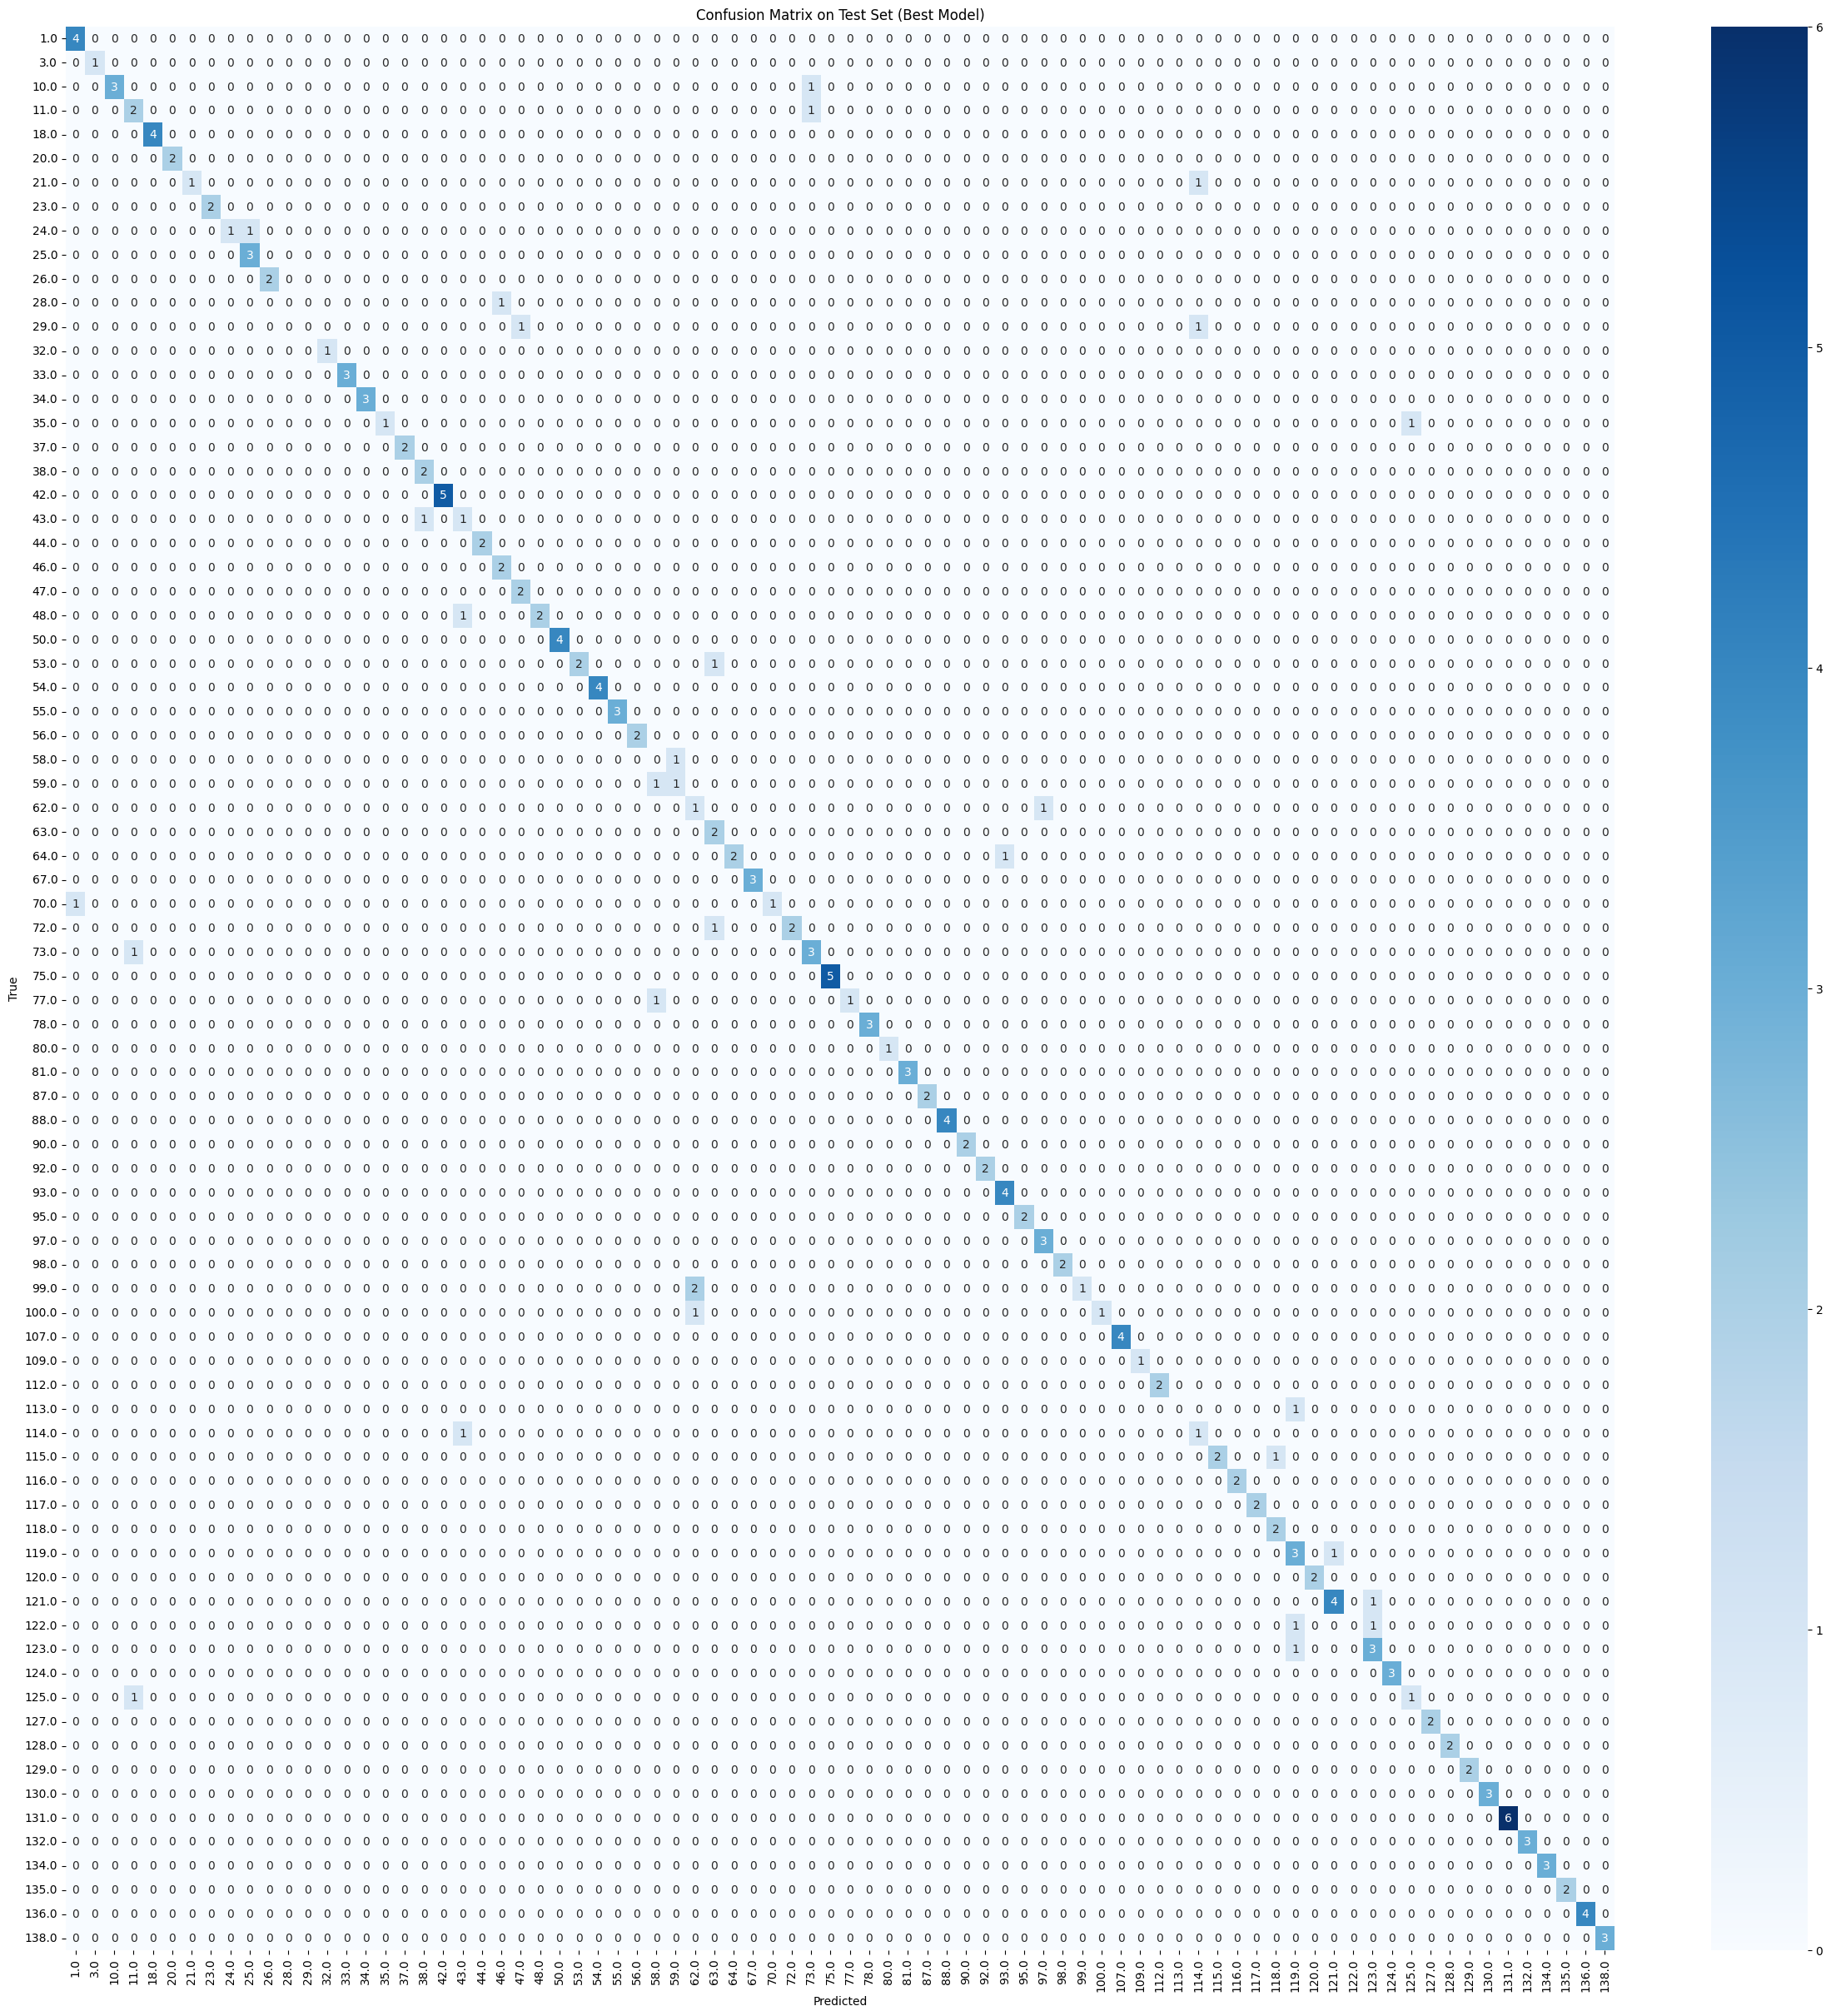

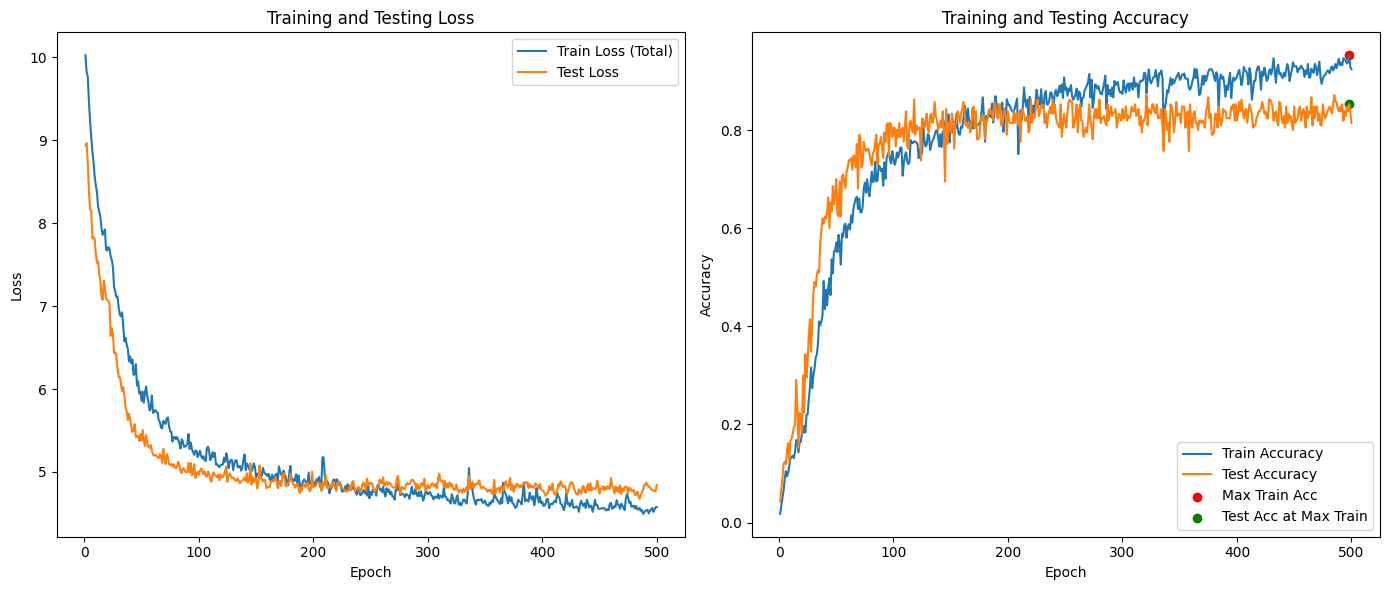

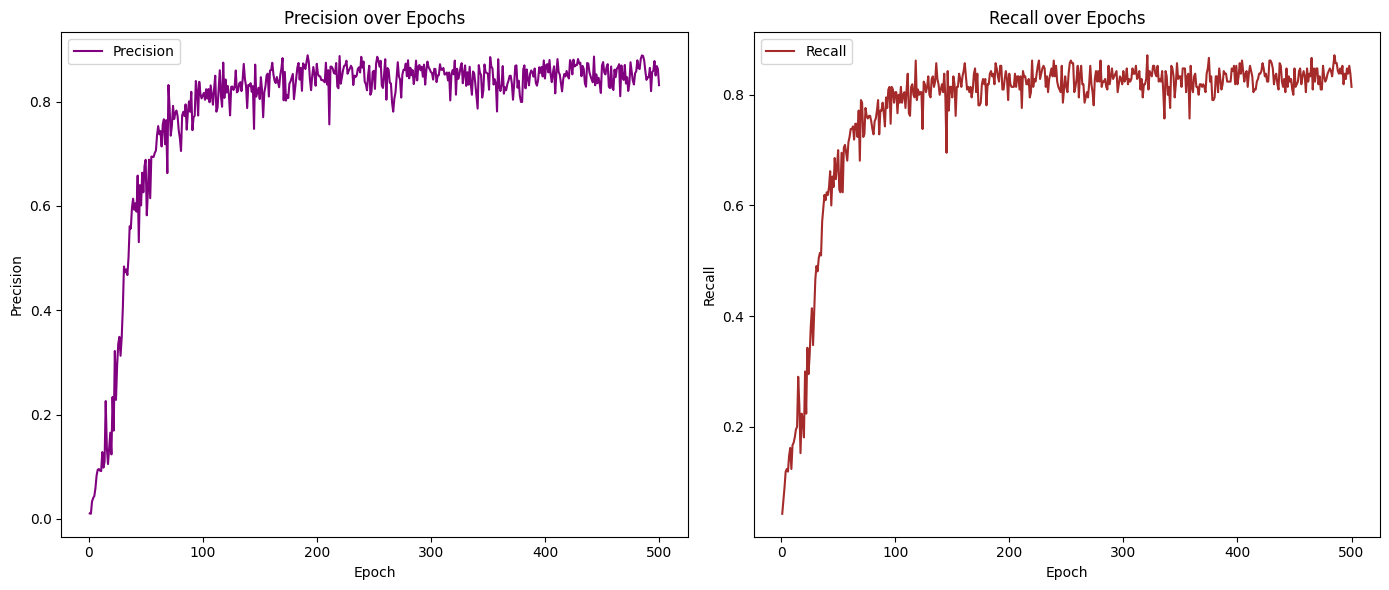

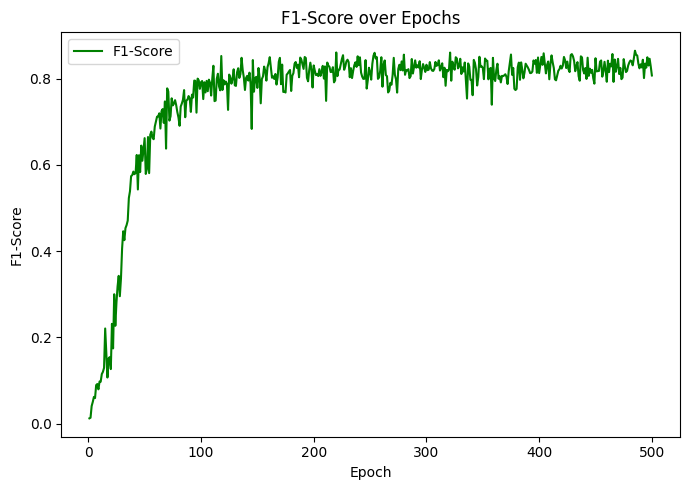

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, r2_score, mean_squared_error
import seaborn as sns
import torch.nn.functional as F
import copy
import random
def set_seed(seed):
    """
    设置所有随机种子以确保结果的可重复性。

    参数:
        seed (int): 随机种子值。
    """
    random.seed(seed)  # Python 的随机模块
    np.random.seed(seed)  # NumPy 的随机模块
    torch.manual_seed(seed)  # PyTorch 的 CPU 随机模块
    torch.cuda.manual_seed(seed)  # PyTorch 的 GPU 随机模块
    torch.cuda.manual_seed_all(seed)  # PyTorch 的多 GPU 随机模块

    # 为了确保 PyTorch 的结果是可重复的
    torch.backends.cudnn.deterministic = True  # 确保使用确定性算法
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的自动优化

seed = 1
set_seed(seed)
# 加载数据
csv_path = '/data/home/wxl22/Classification_of_Varieties/process_utils/processed_spectra.csv'  # 替换为实际文件路径
df = pd.read_csv(csv_path)

# 提取数据
spectra_data = df['data'].apply(eval).to_numpy()  # 转换字符串为数值数组
labels = df['label'].to_numpy()  # 提取标签（如图中为品种代号）

# 数据转换为 NumPy 数组
X = np.array(list(spectra_data))  # (样本数, 特征数)
y = labels

# 对标签进行编码，确保是从 0 开始的连续整数
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将标签转换为 0, 1, 2, ... 格式

# 打印标签映射关系以便于理解
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)
print("Number of classes:", len(label_mapping))

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=seed, stratify=y_encoded
)

# 将数据转换为 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 自定义 Dataset 类
class SpectraDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 创建 Dataset 和 DataLoader
train_dataset = SpectraDataset(X_train, y_train)
test_dataset = SpectraDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, init_embeddings=None):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        if init_embeddings is not None:
            self.embeddings.weight.data.copy_(torch.from_numpy(init_embeddings))
        else:
            self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # 输入形状转换为 (batch_size * sequence_length, embedding_dim)
        inputs = inputs.permute(0, 2, 1).contiguous()  # (batch_size, sequence_length, embedding_dim)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)  # (batch_size * sequence_length, embedding_dim)

        # 计算欧氏距离
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))  # (batch_size * sequence_length, num_embeddings)

        # 找到最近的嵌入向量
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # (batch_size * sequence_length, 1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)  # (batch_size * sequence_length, num_embeddings)

        # 量化
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)  # (batch_size, sequence_length, embedding_dim)

        # 计算VQ损失
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # 添加量化后的梯度
        quantized = inputs + (quantized - inputs).detach()

        quantized = quantized.permute(0, 2, 1).contiguous()  # (batch_size, embedding_dim, sequence_length)

        return quantized, loss


class ImportanceSplitNet(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # 这里是假设我们之前用过某些卷积/拼接操作后，想用 conv_multi 得到 (B, 2*embedding_dim, L)
        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 2, kernel_size=3, padding=1)
        
        # 一个简单的 gating 层：根据通道数(2*embedding_dim)输出一个同维度的权重
        # 如果想让其更加灵活，可以做多层 MLP 或者其他注意力机制
        self.gate_fc = nn.Linear(embedding_dim * 2, embedding_dim * 2)
        
    def forward(self, x):
        """
        x: (B, 6*embedding_dim, L)
           —— 假设在外部已经将三路输出拼接得到 embedding_dim*6 个通道
        """
        # 做卷积得到 (B, 2*embedding_dim, L)
        out = self.conv_multi(x)
        
        # ------------------------------------------------------------
        # 1. 计算每个通道的重要性分数 (使用全局平均池 + 全连接作为简化示例)
        # ------------------------------------------------------------
        
        # (1.1) 对时间维度 L 做“全局平均池化”，得到 (B, 2*embedding_dim)
        gating_input = F.adaptive_avg_pool1d(out, output_size=1).squeeze(-1)
        
        # (1.2) 全连接映射并用 sigmoid 激活，输出范围 [0,1]
        #       形状： (B, 2*embedding_dim)
        gating_score = torch.sigmoid(self.gate_fc(gating_input))
        
        # (1.3) 扩展回 (B, 2*embedding_dim, L)，再与 out 相乘，
        #       使得每个通道的特征被 gating_score 所“加权”
        gating_score = gating_score.unsqueeze(-1)  # (B, 2*embedding_dim, 1)
        gating_score = gating_score.expand(-1, -1, out.size(-1))  # (B, 2*embedding_dim, L)
        
        weighted_out = out * gating_score  # (B, 2*embedding_dim, L)
        
        # ------------------------------------------------------------
        # 2. 根据 gating_score 或 weighted_out 分割“重要特征”和“次要特征”
        # ------------------------------------------------------------
        
        # 假设我们选择一个简单阈值，把通道加权分数 > 0.5 的视为重要特征
        # 注意 gating_score 的 shape 和 out 一样，是(B, 2*embedding_dim, L)
        # 如果只基于通道维度判别，可以先对时间维度再做个聚合(如平均或最大)
        
        # (2.1) 在时间维度再做一次平均，得到每个通道的整体重要性 (B, 2*embedding_dim)
        ch_score = gating_score.mean(dim=-1)
        
        # (2.2) 拿到一个阈值 mask，扩展回 (B, 2*embedding_dim, L)
        threshold = 0.5
        ch_mask = (ch_score > threshold).float().unsqueeze(-1)  # (B, 2*embedding_dim, 1)
        ch_mask = ch_mask.expand(-1, -1, weighted_out.size(-1)) # (B, 2*embedding_dim, L)
        
        # (2.3) 通过 mask 分割重要特征(1)和次要特征(0)
        important_features   = weighted_out * ch_mask
        unimportant_features = weighted_out * (1 - ch_mask)
        
        # 接下来，你可以分别对 important_features 和 unimportant_features 做不同的操作
        # 或者把它们拼回去，或继续后续网络的处理
        
        return important_features, unimportant_features

class Orthogonal_Model(nn.Module):
    def __init__(self, embedding_dim, mlp_in):
        super(Orthogonal_Model, self).__init__()
        self.invariant_axis = nn.Parameter(torch.empty(mlp_in, mlp_in), requires_grad=True)
        self.relevant_axis = nn.Parameter(torch.empty(mlp_in, mlp_in), requires_grad=True)
        nn.init.xavier_uniform_(self.invariant_axis, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.relevant_axis, gain=nn.init.calculate_gain('relu'))
        # 卷积层：将输入的6*embedding_dim通道数降到2*embedding_dim
        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 4, kernel_size=3, padding=1)

        # 定义两个正交的轴向量，形状为 (2*embedding_dim,)
        self.invariant_axis = nn.Parameter(torch.randn(4 * embedding_dim))
        self.relevant_axis = nn.Parameter(torch.randn(4 * embedding_dim))

        # 初始化轴向量，确保它们是正交且单位向量
        with torch.no_grad():
            self.invariant_axis /= torch.norm(self.invariant_axis) + 1e-10
            self.relevant_axis -= torch.dot(self.relevant_axis, self.invariant_axis) * self.invariant_axis
            self.relevant_axis /= torch.norm(self.relevant_axis) + 1e-10

    def similarity(self, feature1, feature2, type='cos'):
        sim = 0
        if type == 'cos':
            norm1 = torch.norm(feature1, dim=1, keepdim=True)
            norm2 = torch.norm(feature2, dim=1, keepdim=True)
            sim = feature1 * feature2 / (norm1 * norm2)
            sim = torch.sum(sim, dim=1)
            # sim = torch.mean(sim)
            sim = torch.max(torch.abs(sim))
        if type == 'pearson':
            sim = []
            for i in range(feature1.shape[0]):
                sim_temp = np.corrcoef(feature1[i].cpu().detach().numpy(), feature2[i].cpu().detach().numpy())
                # print(sim_temp)
                sim.append(sim_temp[0][1])
            sim = max(sim, key=abs)
        return sim

    def orthogonal_loss(self):
            """
            计算 invariant_axis 和 relevant_axis 之间的正交损失。
            目标是最小化它们之间的内积，使得它们正交。
            
            返回:
            - o_loss: 正交损失值
            """
            # 归一化轴向量
            invariant_axis = self.invariant_axis / (torch.norm(self.invariant_axis) + 1e-10)  # (C,)
            relevant_axis = self.relevant_axis / (torch.norm(self.relevant_axis) + 1e-10)      # (C,)
            
            # 计算内积
            o_loss = torch.dot(invariant_axis, relevant_axis)  # 标量
            
            # 计算平方的内积作为损失（更常用）
            o_loss = o_loss ** 2
            
            return o_loss

    def forward(self, x):
            """
            前向传播函数。
            
            参数:
            - x: 输入张量，形状为 (B, 6*embedding_dim, L)
            
            返回:
            - invariant_features: (B, embedding_dim, L)
            - relevant_features: (B, embedding_dim, L)
            """
            # 卷积操作，输出形状为 (B, 2*embedding_dim, L)
            out = self.conv_multi(x)  # (B, 2*embedding_dim, L)
            B, C, L = out.shape  # C = 2*embedding_dim
            
            # 归一化轴向量（如果它们是可训练的，可能需要在每次前向传播中保持正交）
            invariant_axis = self.invariant_axis / (torch.norm(self.invariant_axis) ** 2 + 1e-10)  # (C,)
            relevant_axis = self.relevant_axis / (torch.norm(self.relevant_axis) ** 2 + 1e-10)    # (C,)
            
            # 投影操作
            # out: (B, C, L)
            # invariant_axis: (C,)
            # relevant_axis: (C,)
            
            # 计算投影点积，结果形状为 (B, L)
            invariant_dot = torch.matmul(out.transpose(1, 2), invariant_axis)  # (B, L)
            relevant_dot = torch.matmul(out.transpose(1, 2), relevant_axis)    # (B, L)
            
            # 将投影点积扩展为 (B, 1, L) 以便与轴向量广播相乘
            invariant_dot = invariant_dot.unsqueeze(1)  # (B, 1, L)
            relevant_dot = relevant_dot.unsqueeze(1)    # (B, 1, L)
            
            # 将轴向量扩展为 (1, C, 1) 以便与投影点积相乘
            invariant_axis = invariant_axis.unsqueeze(0).unsqueeze(2)  # (1, C, 1)
            relevant_axis = relevant_axis.unsqueeze(0).unsqueeze(2)    # (1, C, 1)
            
            # 计算投影后的特征，结果形状为 (B, C, L)
            invariant_features = invariant_dot * invariant_axis  # (B, C, L)
            relevant_features = relevant_dot * relevant_axis      # (B, C, L)
            
            # 分割通道维度为两个embedding_dim
            invariant_features = invariant_features[:, :C//2, :]  # (B, embedding_dim, L)
            relevant_features = relevant_features[:, C//2:, :]    # (B, embedding_dim, L)
            
            return invariant_features, relevant_features

class MLP(nn.Module):
    def __init__(self, n_layers, in_dim, hidden, out_dim, dropout):
        super(MLP, self).__init__()
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_dim, hidden))
        for _ in range(n_layers - 2):
            self.lins.append(nn.Linear(hidden, hidden))
        self.lins.append(nn.Linear(hidden, out_dim))
        self.dropout = dropout

        for i in range(len(self.lins)):
            nn.init.xavier_uniform_(self.lins[i].weight, gain=nn.init.calculate_gain('relu'))
    def forward(self, features):
        for i, lin in enumerate(self.lins[:-1]):
            features = lin(features)
            features = F.relu(features)
            features = F.dropout(features, p=self.dropout, training=self.training)
        features = self.lins[-1](features)
        return features


class SpectraCNNWithAttentionVQ(nn.Module):
    def __init__(self, num_classes, num_embeddings=512, embedding_dim=128, commitment_cost=0.25, num_heads=4, init_embeddings=None):
        super(SpectraCNNWithAttentionVQ, self).__init__()
        dropout = 0.3
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(64, embedding_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(embedding_dim)
        self.dropout2 = nn.Dropout(dropout)

        self.conv3 = nn.Conv1d(embedding_dim, embedding_dim * 2, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim * 2)
        self.dropout3 = nn.Dropout(dropout)

        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 自定义的金字塔特征提取部分（通过不同尺度的卷积核提取特征）
        # 金字塔特征提取部分（卷积 + 池化）
        self.conv4 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv5 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=5, padding=2)
        self.bn5 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv6 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=7, padding=3)
        self.bn6 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool6 = nn.MaxPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 2, kernel_size=3, padding=1)  # 更大尺寸的卷积
        # self.split = ImportanceSplitNet(embedding_dim)
        self.orthogonal = Orthogonal_Model(embedding_dim, embedding_dim * 2)

        # 残差连接
        self.residual_conv = nn.Conv1d(1, embedding_dim * 2, kernel_size=1)

        # 向量量化层
        self.vq = VectorQuantizer(num_embeddings, embedding_dim * 2, commitment_cost, init_embeddings)


        # 注意力层
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim * 2, num_heads=num_heads, batch_first=True)

        # 门控层
        self.gate = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=1)

        # 全连接层
        self.fc1 = nn.Linear(embedding_dim * 256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.mlp = MLP(3, embedding_dim * 256, 128, num_classes, dropout)

        # Dropout
        self.dropout4 = nn.Dropout(0.58)

    def forward(self, x):
        # 输入x的形状: (batch_size, 256)
        # 增加通道维度
        x = x.unsqueeze(1)  # (batch_size, 1, 256)
        # 残差连接
        # residual = self.residual_conv(x)  # (batch_size, embedding_dim, 256)
        # 卷积层1
        x = F.relu(self.bn1(self.conv1(x)))  # (batch_size, 64, 256)
        x = self.dropout1(x)
        # 卷积层2
        x = F.relu(self.bn2(self.conv2(x)))  # (batch_size, embedding_dim, 256)
        x = self.dropout2(x)
        # 卷积层3
        x = F.relu(self.bn3(self.conv3(x)))  # (batch_size, embedding_dim * 2, 256)
        x = self.dropout3(x)

        # 通过更大卷积核的卷积提取特征
        x1 = F.relu(self.bn4(self.conv4(x)))
        x1 = self.pool4(x1)
        x2 = F.relu(self.bn5(self.conv5(x)))
        x2 = self.pool5(x2)
        x3 = F.relu(self.bn6(self.conv6(x)))
        x3 = self.pool6(x3)
        # print(x.shape, x3.shape)
        # 将不同尺度的特征拼接起来
        xn = torch.cat([x1, x2, x3], dim=1)  # 沿着通道维度拼接
        # print(xn.shape)
        # xn = self.conv_multi(xn)
        # invariant, spurious = self.split(xn)
        invariant, spurious = self.orthogonal(xn)
        # print(invariant.shape)
        o_loss = self.orthogonal.orthogonal_loss()
        # print(invariant.shape, spurious.shape)


        # 向量量化
        x = self.pool3(x)
        x_vq, vq_loss = self.vq(x)  # (batch_size, embedding_dim * 2, 256)
        # 门控机制
        gate = torch.tanh(self.gate(x))  # (batch_size, embedding_dim * 2, 256)
        # print(invariant.shape, x_vq.shape)
        # print(gate.shape)

        x = gate * invariant + (1 - gate) * x_vq  # (batch_size, embedding_dim * 2, 256)

        # 注意力机制需要输入形状为 (batch_size, sequence_length, embed_dim)
        x = x.permute(0, 2, 1).contiguous()  # (batch_size, 256, embedding_dim * 2)
        # 应用位置编码
        # x = self.positional_encoding(x)  # (batch_size, 256, embedding_dim * 2)

        # 应用多头自注意力
        attn_output, _ = self.attention(x, x, x)  # (batch_size, 256, embedding_dim * 2)
        # 将注意力输出重新排列为卷积层的输入形状
        attn_output = attn_output.permute(0, 2, 1).contiguous()  # (batch_size, embedding_dim * 2, 256)
        # x = x.permute(0, 2, 1).contiguous() + attn_output
        # 展平
        x = attn_output.view(x.size(0), -1)  # (batch_size, embedding_dim * 256)

        # 全连接层1
        x = F.relu(self.fc1(x))  # (batch_size, 128)
        x = self.dropout4(x)
        # 全连接层2
        logits = self.fc2(x)  # (batch_size, num_classes)
        # logits = self.mlp(x)
        # # 计算概率
        probabilities = F.softmax(logits, dim=1)  # (batch_size, num_classes)

        invariant_logits = F.softmax(self.mlp(invariant.view(x.size(0), -1)), dim=1)



        # print("o_loss:", o_loss)
        return logits, probabilities, vq_loss, o_loss, invariant_logits





# 获取类别数
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

# 创建模型
# model = SpectraCNNWithAttention(num_classes=num_classes)
# 参数设置
num_classes = 80  # 类别数
num_embeddings = 128  # VQ代码簿大小
embedding_dim = 64  # VQ嵌入维度
commitment_cost = 0.4  # VQ的commitment cost
num_heads = 64  # 注意力头数

# 创建模型实例
model = SpectraCNNWithAttentionVQ(num_classes=num_classes,
                                    num_embeddings=num_embeddings,
                                    embedding_dim=embedding_dim,
                                    commitment_cost=commitment_cost,
                                    num_heads=num_heads)
print(model)
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 添加权重衰减防止过拟合

# 定义损失函数
criterion_cls = nn.CrossEntropyLoss()

# 检查设备（使用 GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 初始化最佳训练准确率和对应的变量
max_train_accuracy = 0.0
max_train_epoch = 0
test_accuracy_at_max_train = 0.0
test_loss_at_max_train = 0.0
precision_at_max_train = 0.0
recall_at_max_train = 0.0
f1_at_max_train = 0.0

# 初始化用于存储最佳模型在测试集上的标签和预测
best_test_labels = []
best_test_predictions = []

# 存储训练和测试的损失、准确率及其他指标
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []
r2_scores = []
rmse_scores = []

# 训练模型
num_epochs = 500
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # 前向传播
        logits, probabilities, vqloss, o_loss, invariant_logits = model(data)
        loss = criterion_cls(logits, labels) + criterion_cls(invariant_logits, labels) + vqloss + o_loss

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 测试阶段
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels = []
    all_probs = []
    predicted_classes = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            logits, probabilities, vqloss, o_loss, invariant_logits = model(data)
            loss = criterion_cls(logits, labels) + criterion_cls(invariant_logits, labels) + vqloss + o_loss
            running_test_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # 收集所有测试集标签和预测概率
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
            predicted_classes.extend(predicted.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # 计算其他分类指标
    precision = precision_score(all_labels, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(all_labels, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, predicted_classes, average='weighted', zero_division=0)

    # 检查并保存最佳模型及对应的测试指标
    if train_accuracy > max_train_accuracy:
        max_train_accuracy = train_accuracy
        max_train_epoch = epoch
        test_accuracy_at_max_train = test_accuracy
        test_loss_at_max_train = avg_test_loss
        precision_at_max_train = precision
        recall_at_max_train = recall
        f1_at_max_train = f1
        best_test_labels = copy.deepcopy(all_labels)
        best_test_predictions = copy.deepcopy(predicted_classes)
        # print(best_test_labels)

    # 记录损失和准确率
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # 输出每个 epoch 的结果
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_loss:.4f}), "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# 在所有 epoch 结束后，生成混淆矩阵（基于训练准确率最高的模型在测试集上的结果）
# 生成混淆矩阵（测试集上最佳模型的结果）
cm_test = confusion_matrix(best_test_labels, best_test_predictions)
print(len(best_test_predictions))

# 打印训练准确率最高的 epoch 和对应的性能
print("\n==========================")
print(f"训练准确率最高的 Epoch: {max_train_epoch + 1}")
print(f"训练准确率: {max_train_accuracy:.4f}")
print(f"对应的测试准确率: {test_accuracy_at_max_train:.4f}")
print(f"对应的测试损失: {test_loss_at_max_train:.4f}")
print(f"对应的 Precision: {precision_at_max_train:.4f}")
print(f"对应的 Recall: {recall_at_max_train:.4f}")
print(f"对应的 F1-Score: {f1_at_max_train:.4f}")
print("==========================\n")

# 绘制混淆矩阵
plt.figure(figsize=(30, 30))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (Best Model)')
plt.show()

# 绘制损失曲线图
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss (Total)')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# 绘制准确率和其他分类指标曲线图
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

# 标注最高训练准确率点
plt.scatter(max_train_epoch + 1, train_accuracies[max_train_epoch], color='red', label='Max Train Acc')
plt.scatter(max_train_epoch + 1, test_accuracies[max_train_epoch], color='green', label='Test Acc at Max Train')
plt.legend()

plt.tight_layout()
plt.show()


# 绘制 Precision 和 Recall 曲线图
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), precision_scores, label='Precision', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), recall_scores, label='Recall', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制 F1-Score 曲线图
plt.figure(figsize=(7, 5))

plt.plot(range(1, num_epochs + 1), f1_scores, label='F1-Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


下面是做芒果品种预测任务

(200,)
Label Mapping:  {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 48: 46, 49: 47, 50: 48, 51: 49, 52: 50, 53: 51, 54: 52, 55: 53, 56: 54, 57: 55, 58: 56, 59: 57, 60: 58, 61: 59, 62: 60, 63: 61, 64: 62, 65: 63, 66: 64, 67: 65, 68: 66, 69: 67, 70: 68, 71: 69, 72: 70, 73: 71, 74: 72, 75: 73, 76: 74, 77: 75, 82: 76, 86: 77, 90: 78, 91: 79, 95: 80, 96: 81, 103: 82, 104: 83, 105: 84, 107: 85, 108: 86}
Number of classes: 87
Number of classes: 87
SpectraCNNWithAttentionVQ(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv1d(64

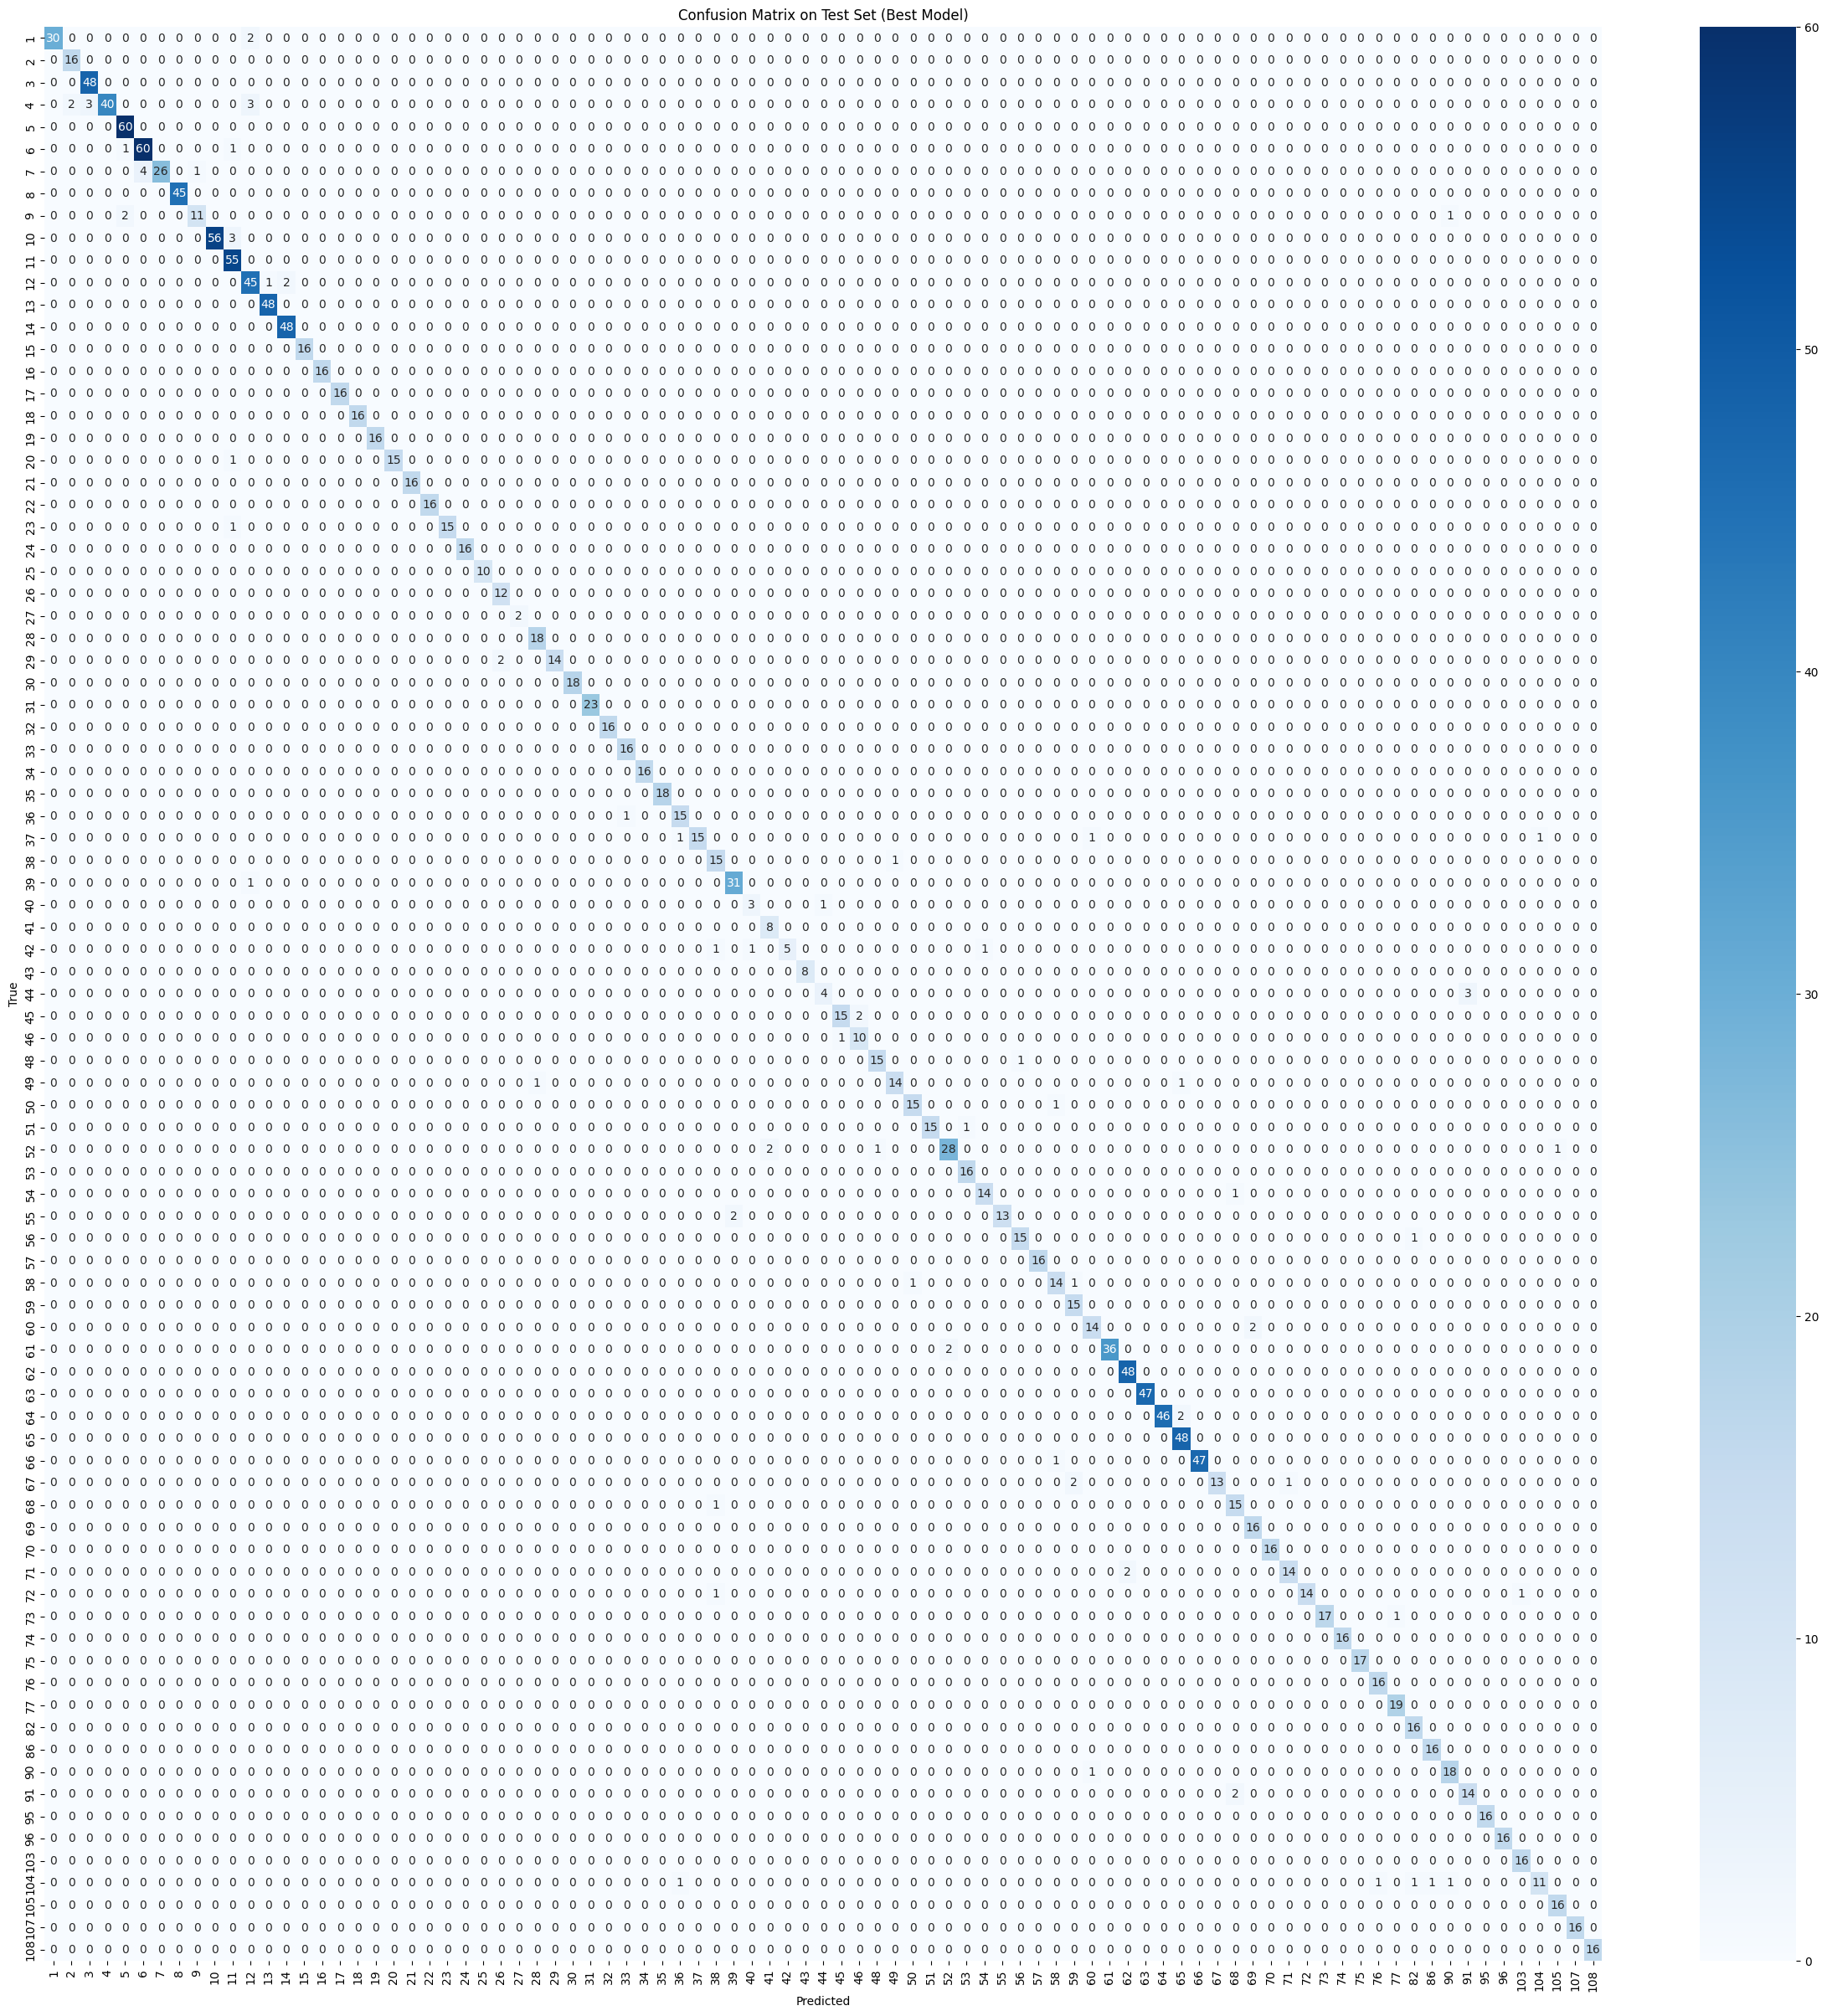

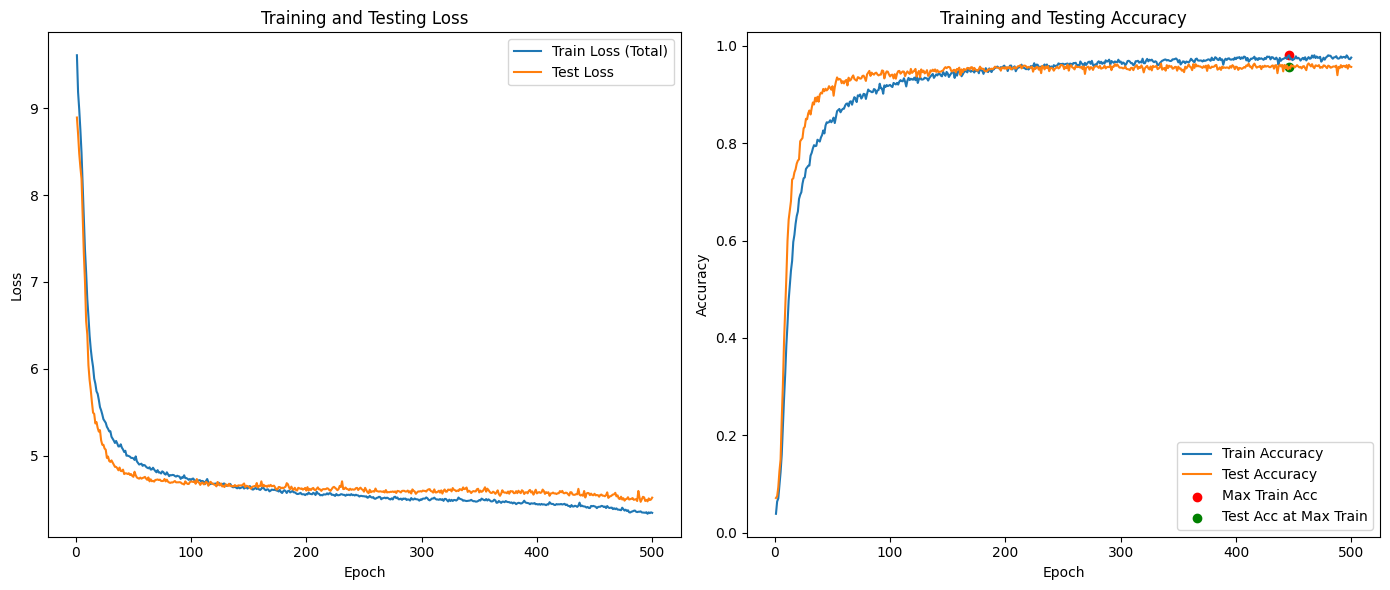

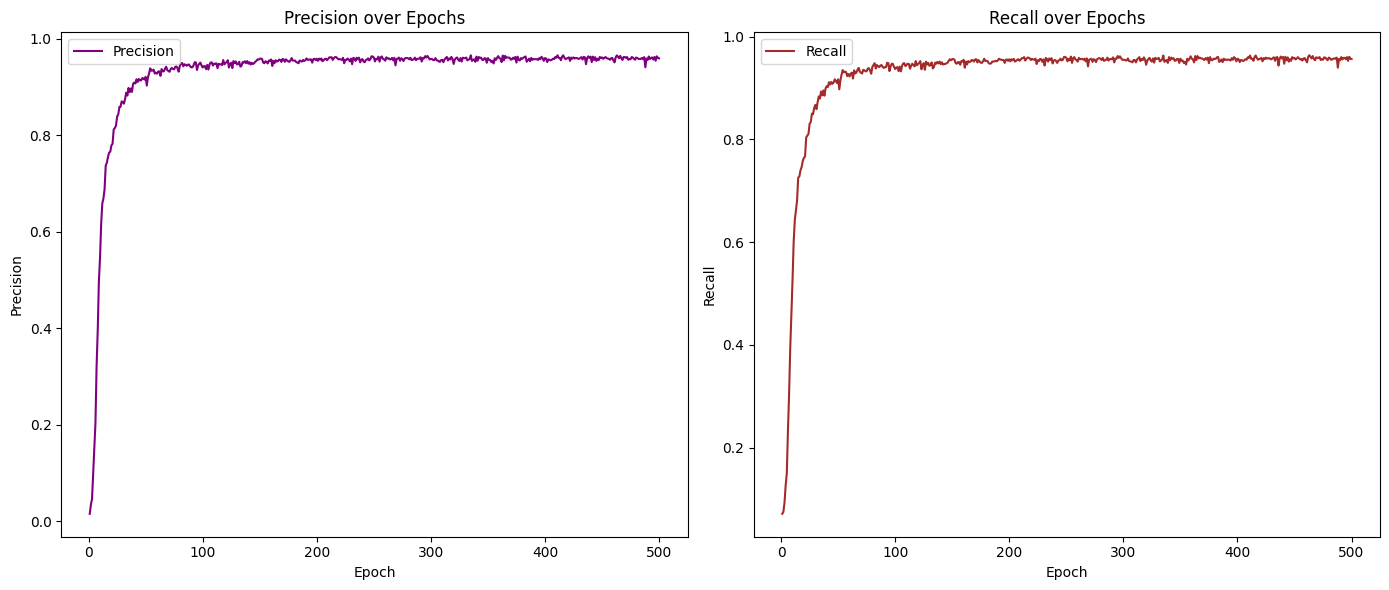

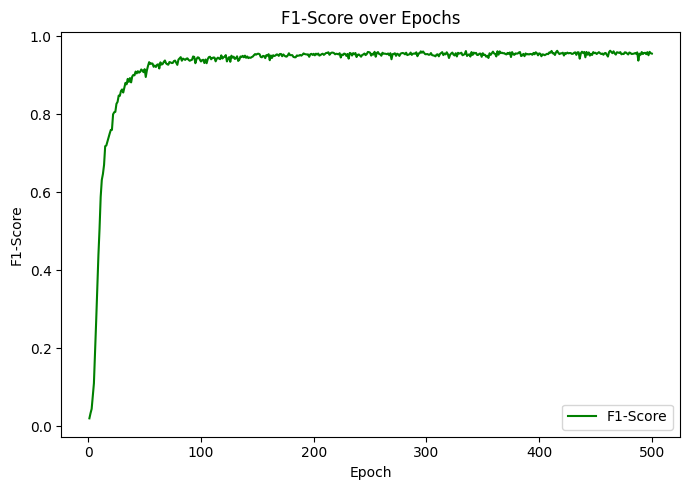

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, r2_score, mean_squared_error
import seaborn as sns
import torch.nn.functional as F
import copy
import random
def set_seed(seed):
    """
    设置所有随机种子以确保结果的可重复性。

    参数:
        seed (int): 随机种子值。
    """
    random.seed(seed)  # Python 的随机模块
    np.random.seed(seed)  # NumPy 的随机模块
    torch.manual_seed(seed)  # PyTorch 的 CPU 随机模块
    torch.cuda.manual_seed(seed)  # PyTorch 的 GPU 随机模块
    torch.cuda.manual_seed_all(seed)  # PyTorch 的多 GPU 随机模块

    # 为了确保 PyTorch 的结果是可重复的
    torch.backends.cudnn.deterministic = True  # 确保使用确定性算法
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的自动优化

seed = 1
set_seed(seed)
# 加载数据
csv_path = '/data/home/wxl22/Classification_of_Varieties/process_utils/hard_green.csv'  # 替换为实际文件路径
df = pd.read_csv(csv_path)

# 提取数据
# spectra_data = df['data'].apply(eval).to_numpy()  # 转换字符串为数值数组
# 筛选列名为数字的列，并保留介于 450 和 1050 之间的列
filtered_columns = [col for col in df.columns if col.isdigit() and 450 <= int(col) < 1050]
filtered_features = df[filtered_columns]
# 将每行数据保存为数组
spectra_data = filtered_features.apply(lambda row: row.values, axis=1).to_numpy()
print(spectra_data[0].shape)

labels = df['Pop'].to_numpy()  # 提取标签（如图中为品种代号）

# 数据转换为 NumPy 数组
X = np.array(list(spectra_data))  # (样本数, 特征数)
y = labels

# 对标签进行编码，确保是从 0 开始的连续整数
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将标签转换为 0, 1, 2, ... 格式

# 打印标签映射关系以便于理解
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)
print("Number of classes:", len(label_mapping))

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=seed, stratify=y_encoded
)

# 将数据转换为 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 自定义 Dataset 类
class SpectraDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 创建 Dataset 和 DataLoader
train_dataset = SpectraDataset(X_train, y_train)
test_dataset = SpectraDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, init_embeddings=None):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        if init_embeddings is not None:
            self.embeddings.weight.data.copy_(torch.from_numpy(init_embeddings))
        else:
            self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # 输入形状转换为 (batch_size * sequence_length, embedding_dim)
        inputs = inputs.permute(0, 2, 1).contiguous()  # (batch_size, sequence_length, embedding_dim)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)  # (batch_size * sequence_length, embedding_dim)

        # 计算欧氏距离
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))  # (batch_size * sequence_length, num_embeddings)

        # 找到最近的嵌入向量
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # (batch_size * sequence_length, 1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)  # (batch_size * sequence_length, num_embeddings)

        # 量化
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)  # (batch_size, sequence_length, embedding_dim)

        # 计算VQ损失
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # 添加量化后的梯度
        quantized = inputs + (quantized - inputs).detach()

        quantized = quantized.permute(0, 2, 1).contiguous()  # (batch_size, embedding_dim, sequence_length)

        return quantized, loss


class ImportanceSplitNet(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # 这里是假设我们之前用过某些卷积/拼接操作后，想用 conv_multi 得到 (B, 2*embedding_dim, L)
        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 2, kernel_size=3, padding=1)
        
        # 一个简单的 gating 层：根据通道数(2*embedding_dim)输出一个同维度的权重
        # 如果想让其更加灵活，可以做多层 MLP 或者其他注意力机制
        self.gate_fc = nn.Linear(embedding_dim * 2, embedding_dim * 2)
        
    def forward(self, x):
        """
        x: (B, 6*embedding_dim, L)
           —— 假设在外部已经将三路输出拼接得到 embedding_dim*6 个通道
        """
        # 做卷积得到 (B, 2*embedding_dim, L)
        out = self.conv_multi(x)
        
        # ------------------------------------------------------------
        # 1. 计算每个通道的重要性分数 (使用全局平均池 + 全连接作为简化示例)
        # ------------------------------------------------------------
        
        # (1.1) 对时间维度 L 做“全局平均池化”，得到 (B, 2*embedding_dim)
        gating_input = F.adaptive_avg_pool1d(out, output_size=1).squeeze(-1)
        
        # (1.2) 全连接映射并用 sigmoid 激活，输出范围 [0,1]
        #       形状： (B, 2*embedding_dim)
        gating_score = torch.sigmoid(self.gate_fc(gating_input))
        
        # (1.3) 扩展回 (B, 2*embedding_dim, L)，再与 out 相乘，
        #       使得每个通道的特征被 gating_score 所“加权”
        gating_score = gating_score.unsqueeze(-1)  # (B, 2*embedding_dim, 1)
        gating_score = gating_score.expand(-1, -1, out.size(-1))  # (B, 2*embedding_dim, L)
        
        weighted_out = out * gating_score  # (B, 2*embedding_dim, L)
        
        # ------------------------------------------------------------
        # 2. 根据 gating_score 或 weighted_out 分割“重要特征”和“次要特征”
        # ------------------------------------------------------------
        
        # 假设我们选择一个简单阈值，把通道加权分数 > 0.5 的视为重要特征
        # 注意 gating_score 的 shape 和 out 一样，是(B, 2*embedding_dim, L)
        # 如果只基于通道维度判别，可以先对时间维度再做个聚合(如平均或最大)
        
        # (2.1) 在时间维度再做一次平均，得到每个通道的整体重要性 (B, 2*embedding_dim)
        ch_score = gating_score.mean(dim=-1)
        
        # (2.2) 拿到一个阈值 mask，扩展回 (B, 2*embedding_dim, L)
        threshold = 0.5
        ch_mask = (ch_score > threshold).float().unsqueeze(-1)  # (B, 2*embedding_dim, 1)
        ch_mask = ch_mask.expand(-1, -1, weighted_out.size(-1)) # (B, 2*embedding_dim, L)
        
        # (2.3) 通过 mask 分割重要特征(1)和次要特征(0)
        important_features   = weighted_out * ch_mask
        unimportant_features = weighted_out * (1 - ch_mask)
        
        # 接下来，你可以分别对 important_features 和 unimportant_features 做不同的操作
        # 或者把它们拼回去，或继续后续网络的处理
        
        return important_features, unimportant_features

class Orthogonal_Model(nn.Module):
    def __init__(self, embedding_dim, mlp_in):
        super(Orthogonal_Model, self).__init__()
        self.invariant_axis = nn.Parameter(torch.empty(mlp_in, mlp_in), requires_grad=True)
        self.relevant_axis = nn.Parameter(torch.empty(mlp_in, mlp_in), requires_grad=True)
        nn.init.xavier_uniform_(self.invariant_axis, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.relevant_axis, gain=nn.init.calculate_gain('relu'))
        # 卷积层：将输入的6*embedding_dim通道数降到2*embedding_dim
        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 4, kernel_size=3, padding=1)

        # 定义两个正交的轴向量，形状为 (2*embedding_dim,)
        self.invariant_axis = nn.Parameter(torch.randn(4 * embedding_dim))
        self.relevant_axis = nn.Parameter(torch.randn(4 * embedding_dim))

        # 初始化轴向量，确保它们是正交且单位向量
        with torch.no_grad():
            self.invariant_axis /= torch.norm(self.invariant_axis) + 1e-10
            self.relevant_axis -= torch.dot(self.relevant_axis, self.invariant_axis) * self.invariant_axis
            self.relevant_axis /= torch.norm(self.relevant_axis) + 1e-10

    def similarity(self, feature1, feature2, type='cos'):
        sim = 0
        if type == 'cos':
            norm1 = torch.norm(feature1, dim=1, keepdim=True)
            norm2 = torch.norm(feature2, dim=1, keepdim=True)
            sim = feature1 * feature2 / (norm1 * norm2)
            sim = torch.sum(sim, dim=1)
            # sim = torch.mean(sim)
            sim = torch.max(torch.abs(sim))
        if type == 'pearson':
            sim = []
            for i in range(feature1.shape[0]):
                sim_temp = np.corrcoef(feature1[i].cpu().detach().numpy(), feature2[i].cpu().detach().numpy())
                # print(sim_temp)
                sim.append(sim_temp[0][1])
            sim = max(sim, key=abs)
        return sim

    def orthogonal_loss(self):
            """
            计算 invariant_axis 和 relevant_axis 之间的正交损失。
            目标是最小化它们之间的内积，使得它们正交。
            
            返回:
            - o_loss: 正交损失值
            """
            # 归一化轴向量
            invariant_axis = self.invariant_axis / (torch.norm(self.invariant_axis) + 1e-10)  # (C,)
            relevant_axis = self.relevant_axis / (torch.norm(self.relevant_axis) + 1e-10)      # (C,)
            
            # 计算内积
            o_loss = torch.dot(invariant_axis, relevant_axis)  # 标量
            
            # 计算平方的内积作为损失（更常用）
            o_loss = o_loss ** 2
            
            return o_loss

    def forward(self, x):
            """
            前向传播函数。
            
            参数:
            - x: 输入张量，形状为 (B, 6*embedding_dim, L)
            
            返回:
            - invariant_features: (B, embedding_dim, L)
            - relevant_features: (B, embedding_dim, L)
            """
            # 卷积操作，输出形状为 (B, 2*embedding_dim, L)
            out = self.conv_multi(x)  # (B, 2*embedding_dim, L)
            B, C, L = out.shape  # C = 2*embedding_dim
            
            # 归一化轴向量（如果它们是可训练的，可能需要在每次前向传播中保持正交）
            invariant_axis = self.invariant_axis / (torch.norm(self.invariant_axis) ** 2 + 1e-10)  # (C,)
            relevant_axis = self.relevant_axis / (torch.norm(self.relevant_axis) ** 2 + 1e-10)    # (C,)
            
            # 投影操作
            # out: (B, C, L)
            # invariant_axis: (C,)
            # relevant_axis: (C,)
            
            # 计算投影点积，结果形状为 (B, L)
            invariant_dot = torch.matmul(out.transpose(1, 2), invariant_axis)  # (B, L)
            relevant_dot = torch.matmul(out.transpose(1, 2), relevant_axis)    # (B, L)
            
            # 将投影点积扩展为 (B, 1, L) 以便与轴向量广播相乘
            invariant_dot = invariant_dot.unsqueeze(1)  # (B, 1, L)
            relevant_dot = relevant_dot.unsqueeze(1)    # (B, 1, L)
            
            # 将轴向量扩展为 (1, C, 1) 以便与投影点积相乘
            invariant_axis = invariant_axis.unsqueeze(0).unsqueeze(2)  # (1, C, 1)
            relevant_axis = relevant_axis.unsqueeze(0).unsqueeze(2)    # (1, C, 1)
            
            # 计算投影后的特征，结果形状为 (B, C, L)
            invariant_features = invariant_dot * invariant_axis  # (B, C, L)
            relevant_features = relevant_dot * relevant_axis      # (B, C, L)
            
            # 分割通道维度为两个embedding_dim
            invariant_features = invariant_features[:, :C//2, :]  # (B, embedding_dim, L)
            relevant_features = relevant_features[:, C//2:, :]    # (B, embedding_dim, L)
            
            return invariant_features, relevant_features

class MLP(nn.Module):
    def __init__(self, n_layers, in_dim, hidden, out_dim, dropout):
        super(MLP, self).__init__()
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_dim, hidden))
        for _ in range(n_layers - 2):
            self.lins.append(nn.Linear(hidden, hidden))
        self.lins.append(nn.Linear(hidden, out_dim))
        self.dropout = dropout

        for i in range(len(self.lins)):
            nn.init.xavier_uniform_(self.lins[i].weight, gain=nn.init.calculate_gain('relu'))
    def forward(self, features):
        for i, lin in enumerate(self.lins[:-1]):
            features = lin(features)
            features = F.relu(features)
            features = F.dropout(features, p=self.dropout, training=self.training)
        features = self.lins[-1](features)
        return features


class SpectraCNNWithAttentionVQ(nn.Module):
    def __init__(self, num_classes, num_embeddings=512, embedding_dim=128, commitment_cost=0.25, num_heads=4, init_embeddings=None):
        super(SpectraCNNWithAttentionVQ, self).__init__()
        dropout = 0.3
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(64, embedding_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(embedding_dim)
        self.dropout2 = nn.Dropout(dropout)

        self.conv3 = nn.Conv1d(embedding_dim, embedding_dim * 2, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim * 2)
        self.dropout3 = nn.Dropout(dropout)

        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 自定义的金字塔特征提取部分（通过不同尺度的卷积核提取特征）
        # 金字塔特征提取部分（卷积 + 池化）
        self.conv4 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv5 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=5, padding=2)
        self.bn5 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv6 = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=7, padding=3)
        self.bn6 = nn.BatchNorm1d(embedding_dim * 2)
        self.pool6 = nn.MaxPool1d(kernel_size=2, stride=2)  # 2x下采样

        self.conv_multi = nn.Conv1d(embedding_dim * 6, embedding_dim * 2, kernel_size=3, padding=1)  # 更大尺寸的卷积
        # self.split = ImportanceSplitNet(embedding_dim)
        self.orthogonal = Orthogonal_Model(embedding_dim, embedding_dim * 2)

        # 残差连接
        self.residual_conv = nn.Conv1d(1, embedding_dim * 2, kernel_size=1)

        # 向量量化层
        self.vq = VectorQuantizer(num_embeddings, embedding_dim * 2, commitment_cost, init_embeddings)


        # 注意力层
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim * 2, num_heads=num_heads, batch_first=True)

        # 门控层
        self.gate = nn.Conv1d(embedding_dim * 2, embedding_dim * 2, kernel_size=1)

        # 全连接层
        self.fc1 = nn.Linear(embedding_dim * 200, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.mlp = MLP(3, embedding_dim * 200, 128, num_classes, dropout)

        # Dropout
        self.dropout4 = nn.Dropout(0.58)

    def forward(self, x):
        # 输入x的形状: (batch_size, 201)
        # 增加通道维度
        x = x.unsqueeze(1)  # (batch_size, 1, 201)
        # 残差连接
        # residual = self.residual_conv(x)  # (batch_size, embedding_dim, 201)
        # 卷积层1
        x = F.relu(self.bn1(self.conv1(x)))  # (batch_size, 64, 201)
        x = self.dropout1(x)
        # 卷积层2
        x = F.relu(self.bn2(self.conv2(x)))  # (batch_size, embedding_dim, 201)
        x = self.dropout2(x)
        # 卷积层3
        x = F.relu(self.bn3(self.conv3(x)))  # (batch_size, embedding_dim * 2, 201)
        x = self.dropout3(x)

        # 通过更大卷积核的卷积提取特征
        x1 = F.relu(self.bn4(self.conv4(x)))
        x1 = self.pool4(x1)
        x2 = F.relu(self.bn5(self.conv5(x)))
        x2 = self.pool5(x2)
        x3 = F.relu(self.bn6(self.conv6(x)))
        x3 = self.pool6(x3)
        # print(x.shape, x3.shape)
        # 将不同尺度的特征拼接起来
        xn = torch.cat([x1, x2, x3], dim=1)  # 沿着通道维度拼接
        # print(xn.shape)
        # xn = self.conv_multi(xn)
        # invariant, spurious = self.split(xn)
        invariant, spurious = self.orthogonal(xn)
        # print(invariant.shape)
        o_loss = self.orthogonal.orthogonal_loss()
        # print(invariant.shape, spurious.shape)


        # 向量量化
        x = self.pool3(x)
        x_vq, vq_loss = self.vq(x)  # (batch_size, embedding_dim * 2, 201)
        # 门控机制
        gate = torch.tanh(self.gate(x))  # (batch_size, embedding_dim * 2, 201)
        # print(invariant.shape, x_vq.shape)
        # print(gate.shape)

        x = gate * invariant + (1 - gate) * x_vq  # (batch_size, embedding_dim * 2, 201)

        # 注意力机制需要输入形状为 (batch_size, sequence_length, embed_dim)
        x = x.permute(0, 2, 1).contiguous()  # (batch_size, 201, embedding_dim * 2)
        # 应用位置编码
        # x = self.positional_encoding(x)  # (batch_size, 201, embedding_dim * 2)

        # 应用多头自注意力
        attn_output, _ = self.attention(x, x, x)  # (batch_size, 201, embedding_dim * 2)
        # 将注意力输出重新排列为卷积层的输入形状
        attn_output = attn_output.permute(0, 2, 1).contiguous()  # (batch_size, embedding_dim * 2, 201)
        # x = x.permute(0, 2, 1).contiguous() + attn_output
        # 展平
        x = attn_output.view(x.size(0), -1)  # (batch_size, embedding_dim * 201)

        # 全连接层1
        x = F.relu(self.fc1(x))  # (batch_size, 128)
        x = self.dropout4(x)
        # 全连接层2
        logits = self.fc2(x)  # (batch_size, num_classes)
        # logits = self.mlp(x)
        # # 计算概率
        probabilities = F.softmax(logits, dim=1)  # (batch_size, num_classes)

        invariant_logits = F.softmax(self.mlp(invariant.view(x.size(0), -1)), dim=1)



        # print("o_loss:", o_loss)
        return logits, probabilities, vq_loss, o_loss, invariant_logits





# 获取类别数
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

# 创建模型
# model = SpectraCNNWithAttention(num_classes=num_classes)
# 参数设置
num_classes = 87  # 类别数
num_embeddings = 512  # VQ代码簿大小
embedding_dim = 64  # VQ嵌入维度
commitment_cost = 0.4  # VQ的commitment cost
num_heads = 128  # 注意力头数

# 创建模型实例
model = SpectraCNNWithAttentionVQ(num_classes=num_classes,
                                    num_embeddings=num_embeddings,
                                    embedding_dim=embedding_dim,
                                    commitment_cost=commitment_cost,
                                    num_heads=num_heads)
print(model)
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 添加权重衰减防止过拟合

# 定义损失函数
criterion_cls = nn.CrossEntropyLoss()

# 检查设备（使用 GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 初始化最佳训练准确率和对应的变量
max_train_accuracy = 0.0
max_train_epoch = 0
test_accuracy_at_max_train = 0.0
test_loss_at_max_train = 0.0
precision_at_max_train = 0.0
recall_at_max_train = 0.0
f1_at_max_train = 0.0

# 初始化用于存储最佳模型在测试集上的标签和预测
best_test_labels = []
best_test_predictions = []

# 存储训练和测试的损失、准确率及其他指标
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []
r2_scores = []
rmse_scores = []

# 训练模型
num_epochs = 500
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # 前向传播
        logits, probabilities, vqloss, o_loss, invariant_logits = model(data)
        loss = criterion_cls(logits, labels) + criterion_cls(invariant_logits, labels) + vqloss + o_loss

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # 测试阶段
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels = []
    all_probs = []
    predicted_classes = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            logits, probabilities, vqloss, o_loss, invariant_logits = model(data)
            loss = criterion_cls(logits, labels) + criterion_cls(invariant_logits, labels) + vqloss + o_loss
            running_test_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # 收集所有测试集标签和预测概率
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
            predicted_classes.extend(predicted.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # 计算其他分类指标
    precision = precision_score(all_labels, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(all_labels, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, predicted_classes, average='weighted', zero_division=0)

    # 检查并保存最佳模型及对应的测试指标
    if train_accuracy > max_train_accuracy:
        max_train_accuracy = train_accuracy
        max_train_epoch = epoch
        test_accuracy_at_max_train = test_accuracy
        test_loss_at_max_train = avg_test_loss
        precision_at_max_train = precision
        recall_at_max_train = recall
        f1_at_max_train = f1
        best_test_labels = copy.deepcopy(all_labels)
        best_test_predictions = copy.deepcopy(predicted_classes)
        # print(best_test_labels)

    # 记录损失和准确率
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # 输出每个 epoch 的结果
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_loss:.4f}), "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# 在所有 epoch 结束后，生成混淆矩阵（基于训练准确率最高的模型在测试集上的结果）
# 生成混淆矩阵（测试集上最佳模型的结果）
cm_test = confusion_matrix(best_test_labels, best_test_predictions)
print(len(best_test_predictions))

# 打印训练准确率最高的 epoch 和对应的性能
print("\n==========================")
print(f"训练准确率最高的 Epoch: {max_train_epoch + 1}")
print(f"训练准确率: {max_train_accuracy:.4f}")
print(f"对应的测试准确率: {test_accuracy_at_max_train:.4f}")
print(f"对应的测试损失: {test_loss_at_max_train:.4f}")
print(f"对应的 Precision: {precision_at_max_train:.4f}")
print(f"对应的 Recall: {recall_at_max_train:.4f}")
print(f"对应的 F1-Score: {f1_at_max_train:.4f}")
print("==========================\n")

# 绘制混淆矩阵
plt.figure(figsize=(30, 30))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (Best Model)')
plt.show()

# 绘制损失曲线图
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss (Total)')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# 绘制准确率和其他分类指标曲线图
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

# 标注最高训练准确率点
plt.scatter(max_train_epoch + 1, train_accuracies[max_train_epoch], color='red', label='Max Train Acc')
plt.scatter(max_train_epoch + 1, test_accuracies[max_train_epoch], color='green', label='Test Acc at Max Train')
plt.legend()

plt.tight_layout()
plt.show()


# 绘制 Precision 和 Recall 曲线图
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), precision_scores, label='Precision', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), recall_scores, label='Recall', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制 F1-Score 曲线图
plt.figure(figsize=(7, 5))

plt.plot(range(1, num_epochs + 1), f1_scores, label='F1-Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
